In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes

from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [2]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 1000  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

### Prepare datasets and model

In [3]:
# List of available datasets:
sorted(dataset_recipes.keys())

['ETTh1',
 'ETTh2',
 'ETTm1',
 'ETTm2',
 'METR_LA',
 'airpassengers',
 'australian_electricity_demand',
 'bitcoin',
 'bitcoin_with_missing',
 'car_parts_with_missing',
 'car_parts_without_missing',
 'cif_2016',
 'cif_2016_12',
 'cif_2016_6',
 'constant',
 'covid_deaths',
 'covid_mobility',
 'dominick',
 'elecdemand',
 'electricity',
 'electricity_hourly',
 'electricity_nips',
 'electricity_weekly',
 'exchange_rate',
 'exchange_rate_nips',
 'extended_web_traffic_with_missing',
 'fred_md',
 'hospital',
 'istanbul_traffic',
 'jena_weather',
 'kaggle_web_traffic_weekly',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kdd_cup_2018_with_missing',
 'kdd_cup_2018_without_missing',
 'london_smart_meters_with_missing',
 'london_smart_meters_without_missing',
 'm1_monthly',
 'm1_quarterly',
 'm1_yearly',
 'm3_monthly',
 'm3_other',
 'm3_quarterly',
 'm3_yearly',
 'm4_daily',
 'm4_hourly',
 'm4_monthly',
 'm4_quarterly',
 'm4_weekly',
 'm4_yearly',
 'm5',
 'monash_m3_

In [4]:
# Load dataset using loader utils
test_data, metadata = get_gluonts_test_dataset(
    "electricity", prediction_length=None, regenerate=False
)
metadata

MetaData(freq='1H', target_dim=1, prediction_length=24, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')

In [5]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(
        f"Salesforce/moirai-1.0-R-{SIZE}",
    ),
    prediction_length=metadata.prediction_length,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=metadata.target_dim,
    feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
    past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

### Make predictions

In [6]:
inp = next(input_it)  # input / lookback window
label = next(label_it)  # label / forecast horizon
forecast = next(forecast_it)  # predictions (GluonTS Forecast object)

In [7]:
inp.keys(), label.keys()

(dict_keys(['target', 'start', 'feat_static_cat', 'item_id']),
 dict_keys(['target', 'start', 'feat_static_cat', 'item_id']))

In [8]:
inp["target"].shape, label["target"].shape

((21044,), (24,))

Moirai produces a _probabilistic forecast_, in the form of a mixture distribution.
```forecast``` is a sample forecast, taking ```num_samples=100``` samples from the mixture distribution per time step.

In [9]:
forecast.samples.shape

(100, 24)

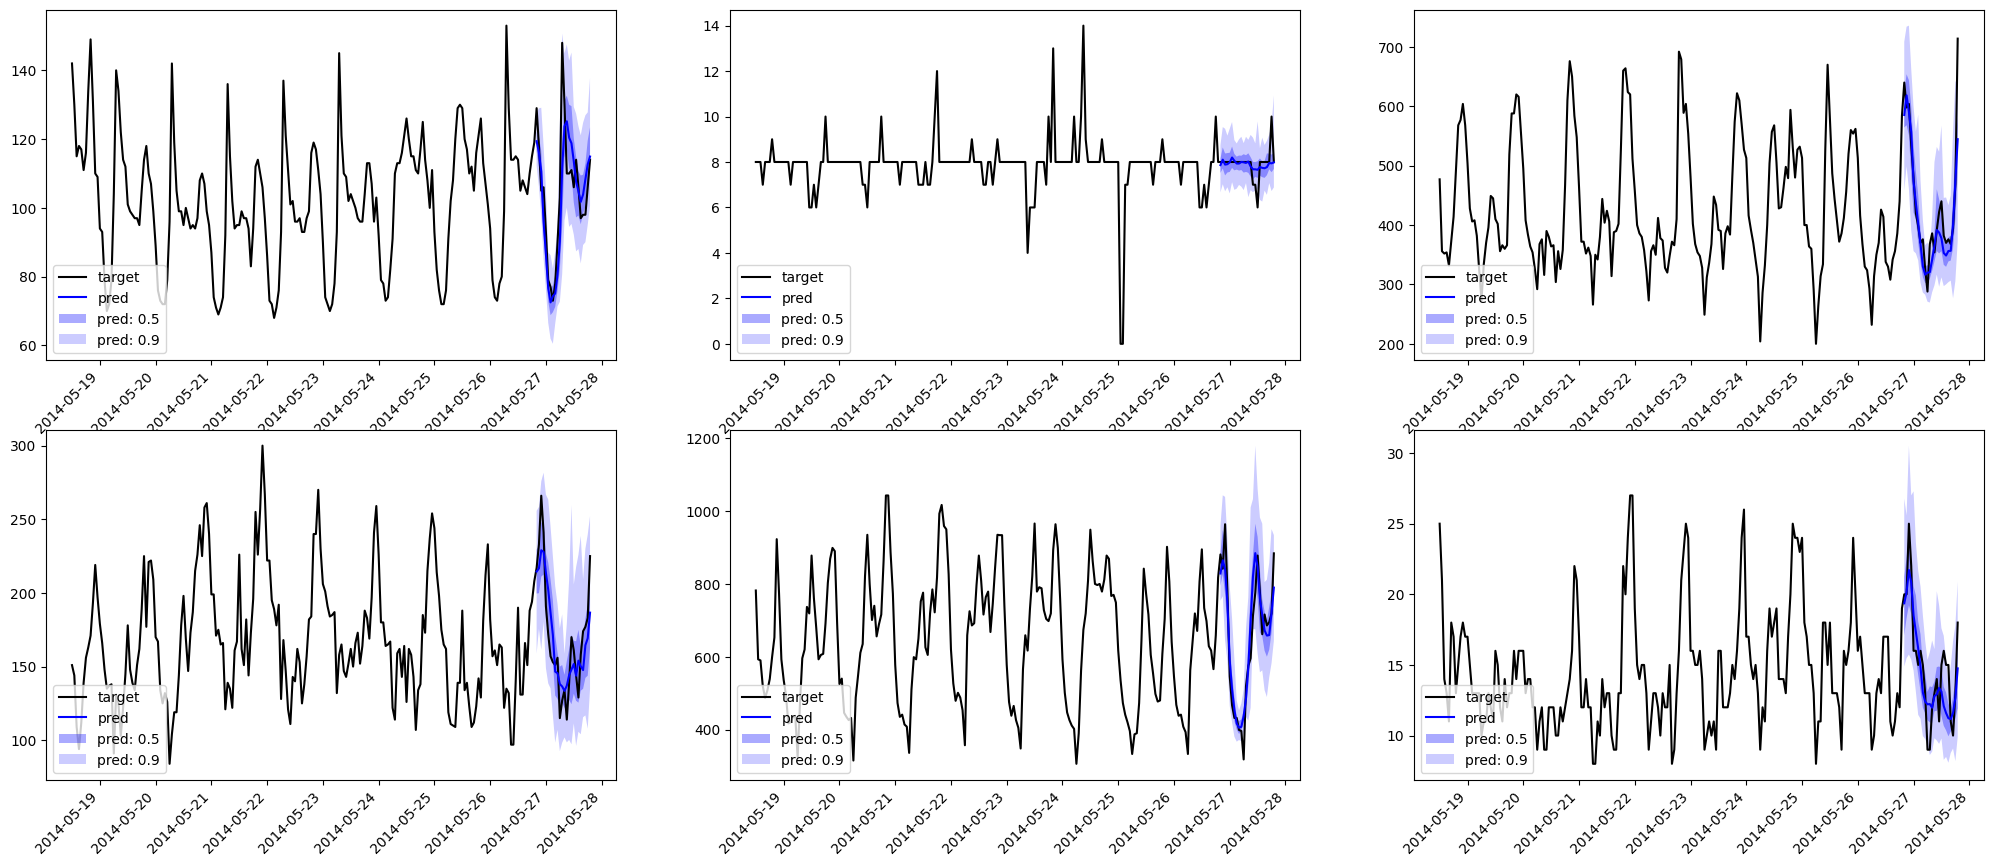

In [10]:
# Visualize forecasts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)